# Week 3: Sales and Customer Analysis

### Import libraries

In [51]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import seaborn as sns
import streamlit as st
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
from IPython.display import display, HTML
from sklearn.cluster import KMeans


### Establish Connection with Sqlite

In [67]:
# Connect to the SQLite database
path = r'C:\Users\calua\Desktop\3Signet\Sales_Adventure_Works.db'
conn = sqlite3.connect(path)

# Define the SQL query
query = """
SELECT 
    strftime('%Y', s.OrderDate) AS year,
    strftime('%m', s.OrderDate) AS month,
    SUM(s.OrderQuantity * p.ProductPrice) AS TotalSales
FROM 
    AdventureWorks_Sales_Data s
JOIN 
    AdventureWorks_Products p 
ON 
    s.ProductKey = p.ProductKey
GROUP BY 
    p.ProductName, year, month
ORDER BY 
    year ASC;
"""

# Execute the query and load the data into a pandas DataFrame
df_sales = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()


## Sales Data Analysis By Year And Month

#### Average sales per month including observation of seasonality and variation

In [68]:
#check Monthly average sales per Month
# Convert 'year' and 'month' columns to datetime format for better plotting
df_sales['Date'] = pd.to_datetime(df_sales['year'] + '-' + df_sales['month'] + '-01')

# Set the Date column as the index
df_sales.set_index('Date', inplace=True)

# Resample data to monthly frequency and calculate mean sales per month
monthly_sales = df_sales['TotalSales'].resample('M').mean()

# Calculate rolling mean and standard deviation to observe variation
rolling_mean = monthly_sales.rolling(window=12).mean()
rolling_std = monthly_sales.rolling(window=12).std()

# Create a Dash application
app = dash.Dash(__name__)

# Define the layout of the dashboard with two graphs
app.layout = html.Div([
    html.H1("Total Sales Over Time Dashboard"),
    
    # First graph: Bar chart for Monthly Average Total Sales
    dcc.Graph(
        id='bar-chart',
        figure={
            'data': [
                go.Bar(
                    x=monthly_sales.index,
                    y=monthly_sales,
                    name='Monthly Average Total Sales',
                    marker={'color': 'skyblue', 'line': {'color': 'white', 'width': 1}}
                )
            ],
            'layout': {
                'title': 'Monthly Average Total Sales Over Time(2015-2017)',
                'xaxis': {'title': 'Date'},
                'yaxis': {'title': 'Average Total Sales'},
                'plot_bgcolor': '#f9f9f9',
                'paper_bgcolor': '#f9f9f9',
                'font': {'color': '#333'},
                'bargap': 0.2,
                'barmode': 'group'
            }
        }
    ),

   
    # Second graph: Line chart for Rolling Mean and Std Dev
    dcc.Graph(
        id='line-chart',
        figure={
            'data': [
                go.Scatter(
                    x=monthly_sales.index, 
                    y=monthly_sales, 
                    mode='lines', 
                    name='Monthly Average Total Sales', 
                    line=dict(color='skyblue')
                ),
                go.Scatter(
                    x=rolling_mean.index, 
                    y=rolling_mean, 
                    mode='lines', 
                    name='Rolling Mean (12 months)', 
                    line=dict(color='red')
                ),
                go.Scatter(
                    x=rolling_std.index, 
                    y=rolling_std, 
                    mode='lines', 
                    name='Rolling Std Dev (12 months)', 
                    line=dict(color='green')
                )
            ],
            'layout': {
                'title': 'Seasonality And Variation Of Total Sales Over Time',
                'xaxis': {'title': 'Date'},
                'yaxis': {'title': 'Total Sales'},
                'plot_bgcolor': '#f9f9f9',
                'paper_bgcolor': '#f9f9f9',
                'font': {'color': '#333'}
            }
        }
    )
])

# Run the Dash application on a different port
if __name__ == '__main__':
    app.run_server(debug=True, port=8051)

# Top 10 Best Performing Products Analysis

In [69]:
# Path to the SQLite database
path = r'C:\Users\calua\Desktop\3Signet\Sales_Adventure_Works.db'

# Connect to the SQLite database
conn = sqlite3.connect(path)

# SQL Query to retrieve top 10 products and their sales from 2015 and July 2016
query = """
SELECT 
    p.ProductName,
    su.SubcategoryName,
    country,
     strftime('%Y', s.OrderDate) AS year,
    strftime('%m', s.OrderDate) AS month,
    SUM(s.OrderQuantity * p.ProductPrice) AS TotalSales,
    SUM(s.OrderQuantity) AS Quantity
FROM 
    AdventureWorks_Sales_Data AS s
INNER JOIN 
    AdventureWorks_Products AS p ON s.ProductKey = p.ProductKey
INNER JOIN 
    AdventureWorks_Product_Subcategories AS su ON p.ProductSubcategoryKey = su.ProductSubcategoryKey
INNER JOIN 
    AdventureWorks_Territories AS t ON t.SalesTerritoryKey = s.TerritoryKey
WHERE 
    year = '2015' OR (year = '2016' AND month = '07')
GROUP BY 
    year, p.ProductName, su.SubcategoryName
ORDER BY 
    TotalSales DESC
LIMIT 10;
"""

# Read the data into a pandas DataFrame
df = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

# Create a styled table with a heading
styled_table = df.style.format({
    "TotalSales": "${:,.2f}",    # Format the TotalSales column to show as currency
    "Quantity": "{:,.0f}"        # Format the Quantity column without decimals
}).background_gradient(cmap="YlGnBu")    # Add a background gradient based on values

# Display the heading and the styled table
display(HTML("<h2>Top 10 Best Performing Products (2015 & July 2016)</h2>"))
display(styled_table)

,ProductName,SubcategoryName,Country,year,month,TotalSales,Quantity
0,"Road-150 Red, 48",Road Bikes,United States,2015,01,"$640,510.33",179
1,"Road-150 Red, 62",Road Bikes,United States,2015,01,"$604,727.63",169
2,"Road-150 Red, 52",Road Bikes,Australia,2015,01,"$601,149.36",168
3,"Road-150 Red, 56",Road Bikes,Australia,2015,01,"$561,788.39",157
4,"Road-150 Red, 44",Road Bikes,United Kingdom,2015,01,"$497,379.53",139
5,"Road-250 Black, 52",Road Bikes,United States,2015,07,"$235,608.75",108
6,"Road-250 Red, 58",Road Bikes,Germany,2015,07,"$231,245.62",106
7,"Road-250 Red, 48",Road Bikes,United States,2015,07,"$219,901.50",90
8,"Road-250 Red, 52",Road Bikes,Australia,2015,07,"$195,468.00",80
9,"Road-250 Black, 48",Road Bikes,Germany,2015,07,"$181,069.69",83


## Sales Distribution of the 10 Best-Performing Products by Region

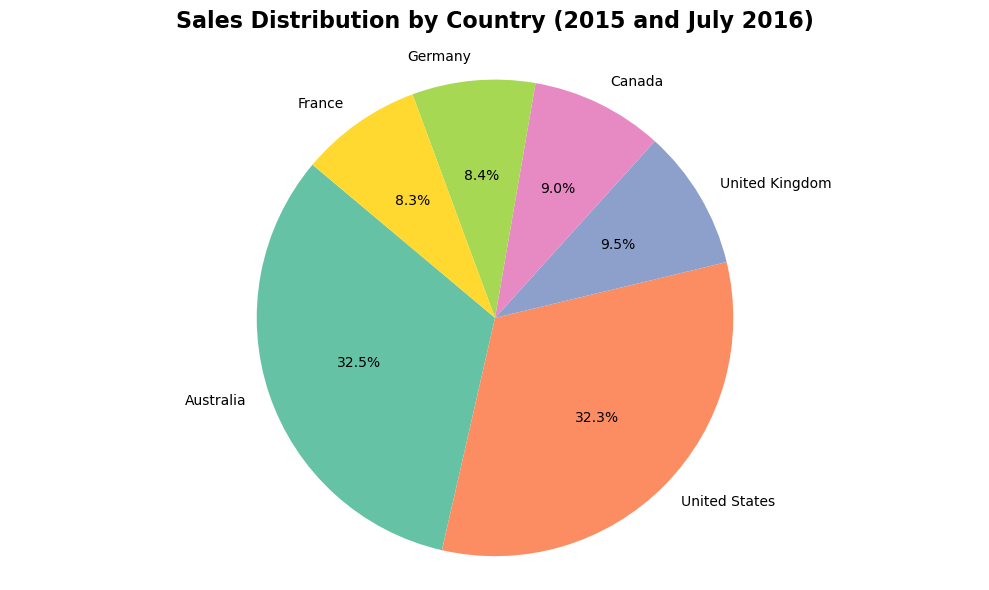

In [32]:
# Path to the SQLite database
path = r'C:\Users\calua\Desktop\3Signet\Sales_Adventure_Works.db'

# Connect to the SQLite database
conn = sqlite3.connect(path)

# SQL Query to retrieve top 10 sales per region from 2015 and July 2016
query = """
SELECT 
    country,
    strftime('%Y', s.OrderDate) AS year,
    strftime('%m', s.OrderDate) AS month,
    SUM(s.OrderQuantity * p.ProductPrice) AS TotalSales,
    SUM(s.OrderQuantity) AS Quantity
FROM 
    AdventureWorks_Sales_Data AS s
INNER JOIN 
    AdventureWorks_Products AS p ON s.ProductKey = p.ProductKey
INNER JOIN 
    AdventureWorks_Product_Subcategories AS su ON p.ProductSubcategoryKey = su.ProductSubcategoryKey
INNER JOIN 
    AdventureWorks_Territories AS t ON t.SalesTerritoryKey = s.TerritoryKey
WHERE 
    year = '2015' OR (year = '2016' AND month = '07')
GROUP BY 
            country
ORDER BY 
    TotalSales DESC
LIMIT 10;
"""

# Read the data into a pandas DataFrame
df_Region = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

# Create a pie chart with a color scheme
plt.figure(figsize=(10, 6))
colors = plt.cm.Set2(range(len(df_Region)))  # Set2 qualitative color map

# Add padding to the title for spacing
plt.pie(df_Region['TotalSales'], labels=df_Region['Country'], autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Sales Distribution by Country (2015 and July 2016)', fontsize=16, fontweight='bold', pad=20)  # Add padding
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.


# Show the chart
plt.tight_layout()
plt.show()

## Demand Analysis (Quantity Sold)

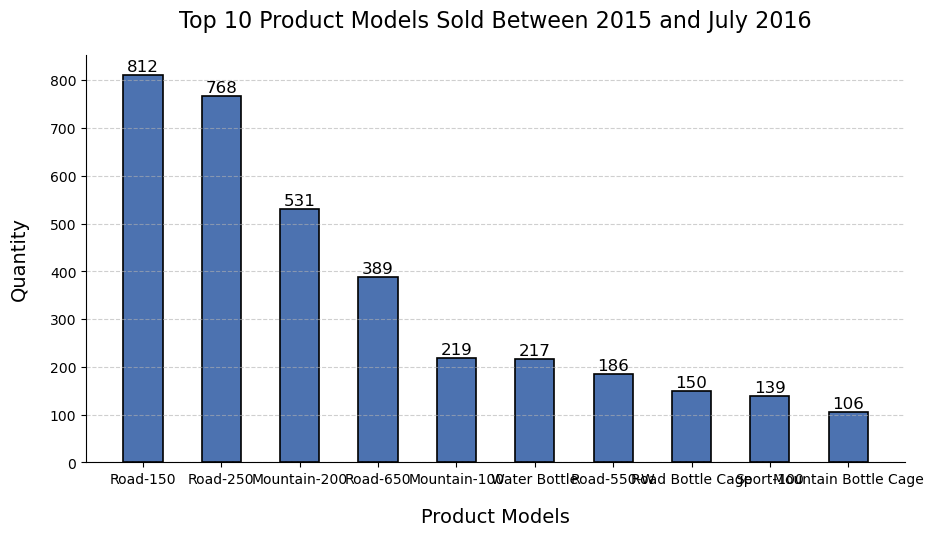

In [43]:
## check quantity of product sold
# Path to the SQLite database
path = r'C:\Users\calua\Desktop\3Signet\Sales_Adventure_Works.db'

# Connect to the SQLite database
conn = sqlite3.connect(path)

# SQL Query to retrieve top 10 sales per region from 2015 and July 2016
query = """
SELECT 
    ModelName,
    strftime('%Y', s.OrderDate) AS year,
    strftime('%m', s.OrderDate) AS month,
     SUM(s.OrderQuantity) AS Quantity
FROM 
    AdventureWorks_Sales_Data AS s
INNER JOIN 
    AdventureWorks_Products AS p ON s.ProductKey = p.ProductKey
INNER JOIN 
    AdventureWorks_Product_Subcategories AS su ON p.ProductSubcategoryKey = su.ProductSubcategoryKey
INNER JOIN 
    AdventureWorks_Territories AS t ON t.SalesTerritoryKey = s.TerritoryKey
WHERE 
    year = '2015' OR (year = '2016' AND month = '07')
GROUP BY 
           ModelName
ORDER BY 
   Quantity DESC
LIMIT 10;
"""

# Read the data into a pandas DataFrame
df_quantity = pd.read_sql_query(query, conn)

# Close the connection
conn.close()


# Set figure size and background
plt.figure(figsize=(10, 6), facecolor='white')

# Create bar chart with a professional color scheme and layout
bars = plt.bar(df_quantity['ModelName'], df_quantity['Quantity'], color='#4C72B0', edgecolor='black', linewidth=1.2, width=0.5)

# Title and labels with custom fonts
plt.title('Top 10 Product Models Sold Between 2015 and July 2016', fontsize=16, pad=20)
plt.xlabel('Product Models', fontsize=14, labelpad=15)
plt.ylabel('Quantity', fontsize=14, labelpad=15)

# Add gridlines with transparency and behind the bars
plt.grid(axis='y', linestyle='--', alpha=0.6, zorder=0)

# Remove top and right borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval}', ha='center', va='bottom', fontsize=12)

# Tidy up the layout and increase spacing between elements
plt.tight_layout(pad=3.0)

# Show the plot
plt.show()

### Overall Trends - Seasonal Effects

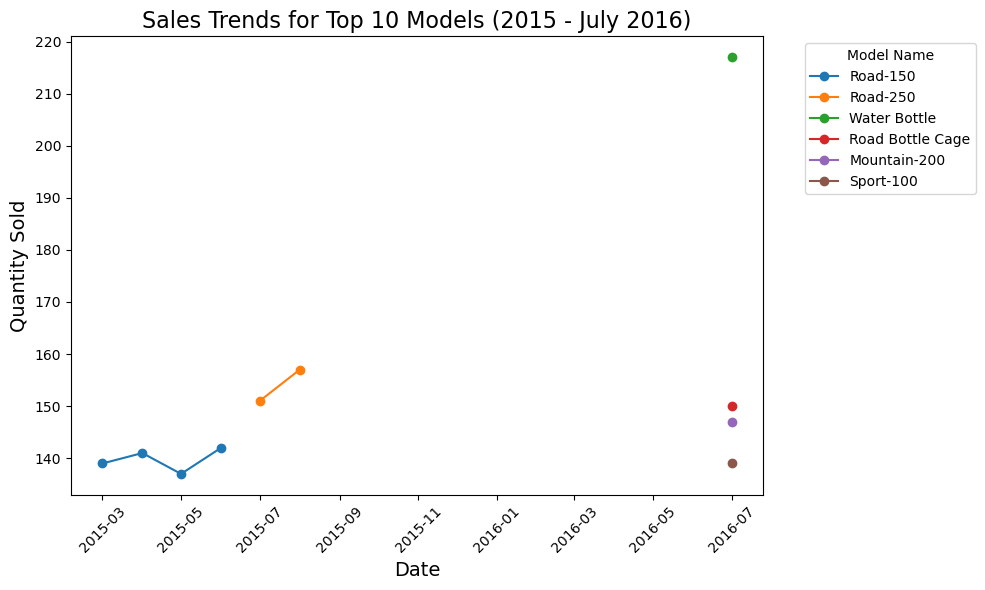

In [49]:
## check quantity of product sold
# Path to the SQLite database
path = r'C:\Users\calua\Desktop\3Signet\Sales_Adventure_Works.db'

# Connect to the SQLite database
conn = sqlite3.connect(path)

# SQL Query to retrieve top 10 sales per region from 2015 and July 2016
query = """
SELECT 
    ModelName,
    strftime('%Y', s.OrderDate) AS year,
    strftime('%m', s.OrderDate) AS month,
     SUM(s.OrderQuantity) AS Quantity
FROM 
    AdventureWorks_Sales_Data AS s
INNER JOIN 
    AdventureWorks_Products AS p ON s.ProductKey = p.ProductKey
INNER JOIN 
    AdventureWorks_Product_Subcategories AS su ON p.ProductSubcategoryKey = su.ProductSubcategoryKey
INNER JOIN 
    AdventureWorks_Territories AS t ON t.SalesTerritoryKey = s.TerritoryKey
WHERE 
    year = '2015' OR (year = '2016' AND month = '07')
GROUP BY 
           Year,MONTH,ModelName
ORDER BY 
   Quantity DESC
LIMIT 10;
"""
# Read the data into a pandas DataFrame
df_trends = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

# Step 3: Convert year and month into a proper datetime format
df_trends['Date'] = pd.to_datetime(df_trends['year'] + '-' + df_trends['month'] + '-01')

# Step 4: Sort the data by Date
df_trends = df_trends.sort_values(by='Date')

# Step 5: Plot the line chart using Matplotlib
plt.figure(figsize=(10, 6))

# Loop through each product model to plot its sales trend
for model in df_trends['ModelName'].unique():
    model_data = df_trends[df_trends['ModelName'] == model]
    plt.plot(model_data['Date'], model_data['Quantity'], marker='o', label=model)

# Add title and labels
plt.title('Sales Trends for Top 10 Models (2015 - July 2016)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Quantity Sold', fontsize=14)

# Add a legend to differentiate models
plt.legend(title='Model Name', bbox_to_anchor=(1.05, 1), loc='upper left')

# Format the date on the x-axis for better readability
plt.xticks(rotation=45)

# Display the line chart
plt.tight_layout()
plt.show()

# Step 6: Close the database connection
conn.close()





# Customer Demographics And Purchasing Pattens 

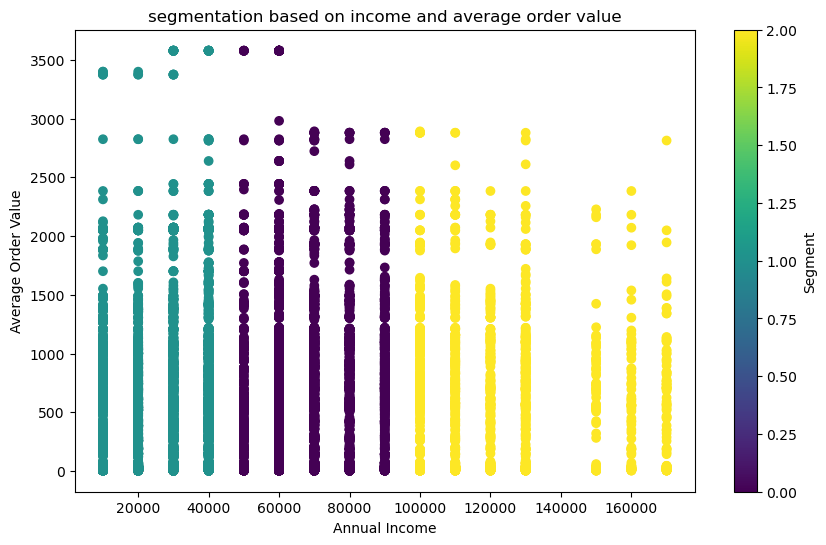

In [57]:
## segmentation based on income and average order value
# Path to the SQLite database
path = r'C:\Users\calua\Desktop\3Signet\Sales_Adventure_Works.db'

# Connect to the SQLite database
conn = sqlite3.connect(path)

# SQL Query to retrieve top 10 sales per region from 2015 and July 2016
query = """
SELECT 
    c.CustomerKey,
    c.AnnualIncome,
    t.Region,  -- Ensure that the Region comes from the Territories table
    COUNT(s.OrderNumber) AS PurchaseFrequency,
    AVG(p.ProductPrice) AS AverageOrderValue
FROM 
    AdventureWorks_Sales_Data AS s
INNER JOIN 
    AdventureWorks_Products AS p ON s.ProductKey = p.ProductKey
INNER JOIN 
    AdventureWorks_Product_Subcategories AS su ON p.ProductSubcategoryKey = su.ProductSubcategoryKey
INNER JOIN 
    AdventureWorks_Territories AS t ON t.SalesTerritoryKey = s.TerritoryKey
INNER JOIN 
    AdventureWorks_Customers AS c ON s.CustomerKey = c.CustomerKey
GROUP BY 
    c.CustomerKey, c.AnnualIncome, t.Region;  -- Ensure to include 't.Region' in the GROUP BY clause
"""
# Read the data into a pandas DataFrame
df_segm = pd.read_sql_query(query, conn)

# Drop missing values or fill them as necessary
df_segm.dropna(inplace=True)

# Step 4: Segmentation
# Selecting features for segmentation
features = df_segm[['AnnualIncome', 'PurchaseFrequency', 'AverageOrderValue']]

# Normalize the data if necessary
# (Optional) You can use StandardScaler or MinMaxScaler for normalization

# Apply KMeans clustering
#kmeans = KMeans(n_clusters=3)  # Adjust number of clusters as needed
kmeans = KMeans(n_clusters=3, n_init=10) 
df_segm['Segment'] = kmeans.fit_predict(features)

# Step 5: Create Customer Profiles
# Group by segment and summarize
customer_profiles = df_segm.groupby('Segment').agg({
    'AnnualIncome': 'mean',
    'PurchaseFrequency': 'mean',
    'AverageOrderValue': 'mean',
    'Region': lambda x: x.mode()[0],  # Get the most common location
}).reset_index()


# (Optional) Visualize the segmentation
plt.figure(figsize=(10, 6))
plt.scatter(df_segm['AnnualIncome'], df_segm['AverageOrderValue'], c=df_segm['Segment'], cmap='viridis', marker='o')
plt.title('segmentation based on income and average order value')
plt.xlabel('Annual Income')
plt.ylabel('Average Order Value')
plt.colorbar(label='Segment')
plt.show()

# Step 6: Close the database connection
conn.close()



###  Show the distribution of customers by region


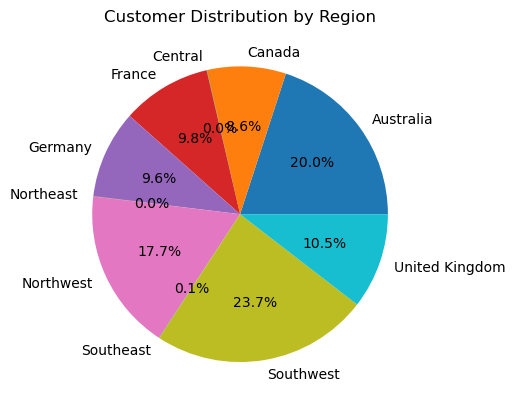

In [58]:
# Group by region and count the number of customers
region_customer_count = df_segm.groupby('Region')['CustomerKey'].count()

# Plotting the pie chart
region_customer_count.plot(kind='pie', autopct='%1.1f%%')
plt.title('Customer Distribution by Region')
plt.ylabel('')  # Hide the y-label
plt.show()

### Average order value by region

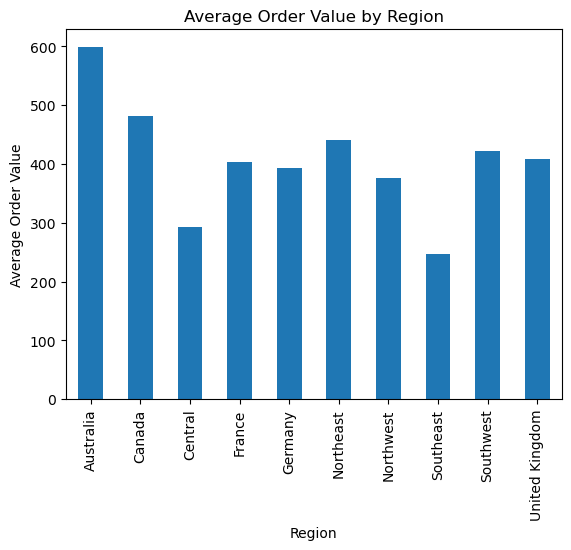

In [59]:
# Group by region and calculate the average order value
region_avg_order_value = df_segm.groupby('Region')['AverageOrderValue'].mean()

# Plotting the bar chart
region_avg_order_value.plot(kind='bar')
plt.title('Average Order Value by Region')
plt.xlabel('Region')
plt.ylabel('Average Order Value')
plt.show()

### The distribution of purchase frequency


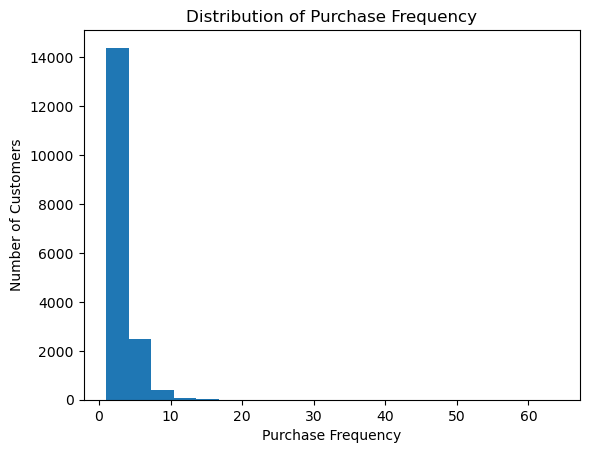

In [62]:
# Plotting the histogram
df_segm['PurchaseFrequency'].plot(kind='hist', bins=20)
plt.title('Distribution of Purchase Frequency')
plt.xlabel('Purchase Frequency')
plt.ylabel('Number of Customers')
plt.show()